# Aggregation of the parcels of the different atlas

## Automatic aggregation (K-means, Spectral Clustering, Hierarchical Clustering)

In [149]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nilearn
import pydicom as dicom
import torch

from tqdm.notebook import tqdm

In [150]:
## FUNCTION TO SAVE DATA IN RIGHT FORMAT FOR xGW-GAT ##

DATA_FOLDER = './comparison_data/ABIDE/'

def save_data(DATA_FOLDER, correlation_matrices, scores):
    try:
        conn = torch.Tensor(correlation_matrices)
        print(f"Connectome (X) shape: {conn.shape}") # n_ROIs, n_ROIs, n_subjects

        scores = torch.LongTensor(scores)
        print(f"Gait scores (y) shape: {scores.shape}") # n_subjects
        torch.save(conn, f"{DATA_FOLDER}/connectomes_0.npy")
        torch.save(scores, f"{DATA_FOLDER}/scores.npy")

        merged_df_multi = pd.DataFrame(list(zip(correlation_matrices, scores, [i for i in range(len(scores))])),
                columns =['corr', 'labels', 'p_ids'])
        records_multi = merged_df_multi.to_records(index=False)
        data_multi = np.array(records_multi, dtype=records_multi.dtype.descr)
        np.save(f"{DATA_FOLDER}/private_binary.npy", data_multi)
        print("Data saved successfully!")
        return True
    except Exception as e:
        print("Error saving data: ", e)
        return False


In [151]:
# Load the .npy files for the ABIDE dataset
data_aal = np.load('./data_abide_cc200/ABIDE_pcp/abide.npy', allow_pickle=True).item()

In [152]:
data_aal["corr"].shape

(1009, 200, 200)

In [153]:
# check if data_aal["corr"] has nans 
print(np.isnan(data_aal["corr"]).any())
# check if data_aal["corr"] has infs
print(np.isinf(data_aal["corr"]).any())

False
False


In [80]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.manifold import TSNE

def aggregate_matrices(data, n_clusters, method='kmeans'):
    """
    Applies clustering to each subject's correlation matrix and aggregates 
    these into a smaller matrix.

    :param data: 3D numpy array, shape (subjects, nodes, nodes)
    :param n_clusters: int, the number of clusters for aggregation
    :param method: str, 'kmeans', 'spectral', or 'hierarchical' for the clustering method
    :return: 2D numpy array, aggregated matrix
    """
    n_subjects = data.shape[0]
    store = np.zeros((n_subjects, n_clusters, n_clusters))

    for subject in tqdm(range(n_subjects)):
        corr_matrix = data[subject]

        # Apply the chosen clustering method
        if method == 'kmeans':
            flattened_data = corr_matrix.reshape((corr_matrix.shape[0], -1))
            model = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            labels = model.fit_predict(flattened_data)
        elif method == 't-sne':
            flattened_data = corr_matrix.reshape((corr_matrix.shape[0], -1))
            model = TSNE(n_components=n_clusters, random_state=0, method='exact')
            labels = model.fit_transform(flattened_data)
        elif method == 'spectral':
            model = SpectralClustering(n_clusters=n_clusters)
            labels = model.fit_predict(corr_matrix)
        elif method == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_clusters)
            labels = model.fit_predict(corr_matrix)
        else:
            raise ValueError("Invalid method. Choose 'kmeans', 'spectral', or 'hierarchical'.")

        # Aggregate the correlations for each subject
        for i in range(n_clusters):
            for j in range(n_clusters):
                indices_i = np.where(labels == i)[0]
                indices_j = np.where(labels == j)[0]
                avg_correlation = np.mean([corr_matrix[x, y] for x in indices_i for y in indices_j])
                store[subject, i, j] = avg_correlation

    return store, labels


In [86]:
agg_data, agg_labels = aggregate_matrices(data_aal["corr"], 15, 'kmeans')

print(agg_data.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data.shape[0]):
    for j in range(agg_data.shape[1]):
        for k in range(agg_data.shape[2]):
            if np.isnan(agg_data[i, j, k]):
                n_nan += 1
print(n_nan)


  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 15, 15)
0


In [82]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

dataset = datasets.fetch_atlas_aal(version='SPM12')
atlas_filename = dataset.maps
labels = dataset.labels
print('Length of labels:', len(labels))


from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in np.unique(agg_labels):
    indices = np.where(agg_labels == region)[0]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data[0, :, :],
    coordinates_avg,
    edge_threshold="80%",
    title="Hierarchical Clustering AAL atlas",
)

Length of labels: 116


IndexError: index 120 is out of bounds for axis 0 with size 116

In [87]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/automatic/'
save_data(DATA_FOLDER_AGG, agg_data, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 15, 15])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

### Manual aggregation of known regions using NiLearn

In [156]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
# CC200
dataset = datasets.fetch_atlas_craddock_2012()
labels = dataset.labels
print('Length of labels:', len(labels))

AttributeError: labels

In [122]:
labels = labels + labels_sub

In [123]:
labels

['Background',
 'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipita

In [138]:
# Aggregate the corr matrices in data_all according to the brain_region_groups

def aggregate_matrices_manual(data, groups_dict):
    """
    Applies clustering to each subject's correlation matrix and aggregates 
    these into a smaller matrix.

    :param data: 3D numpy array, shape (subjects, nodes, nodes)
    :param groups_dict: dictionary, keys are names of brain regions, values are lists of node indices
    :return: 2D numpy array, aggregated matrix
    """
    n_subjects = data.shape[0]
    n_regions = len(groups_dict)
    store = np.zeros((n_subjects, n_regions, n_regions))

    for subject in tqdm(range(n_subjects)):
        corr_matrix = data[subject]

        # Aggregate the correlations for each subject
        for i, region_i in enumerate(groups_dict.keys()):
            for j, region_j in enumerate(groups_dict.keys()):
                indices_i = groups_dict[region_i]
                indices_j = groups_dict[region_j]
                indices_i = [labels.index(x) for x in indices_i]
                indices_j = [labels.index(x) for x in indices_j]
                # keep only indices that are in the corr_matrix
                indices_i = [x for x in indices_i if x < corr_matrix.shape[0]]
                indices_j = [x for x in indices_j if x < corr_matrix.shape[0]]
                avg_correlation = np.mean([corr_matrix[x, y] for x in indices_i for y in indices_j])
                store[subject, i, j] = avg_correlation

    return store

#### Coarse-grained 7 groups

In [146]:
brain_region_groups = {
    "Frontal Lobe Regions": [
        "Left Frontal Pole", "Right Frontal Pole",
        "Left Superior Frontal Gyrus", "Right Superior Frontal Gyrus",
        "Left Middle Frontal Gyrus", "Right Middle Frontal Gyrus",
        "Left Inferior Frontal Gyrus, pars triangularis", "Right Inferior Frontal Gyrus, pars triangularis",
        "Left Inferior Frontal Gyrus, pars opercularis", "Right Inferior Frontal Gyrus, pars opercularis",
        "Left Precentral Gyrus", "Right Precentral Gyrus",
        "Left Frontal Medial Cortex", "Right Frontal Medial Cortex",
        "Left Frontal Orbital Cortex", "Right Frontal Orbital Cortex",
        "Left Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)", "Right Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)",
        "Left Frontal Operculum Cortex", "Right Frontal Operculum Cortex",
        "Left Insular Cortex", "Right Insular Cortex"
    ],
    "Temporal and Parietal Lobe Regions": [
        "Left Temporal Pole", "Right Temporal Pole",
        "Left Superior Temporal Gyrus, anterior division", "Right Superior Temporal Gyrus, anterior division",
        "Left Superior Temporal Gyrus, posterior division", "Right Superior Temporal Gyrus, posterior division",
        "Left Middle Temporal Gyrus, anterior division", "Right Middle Temporal Gyrus, anterior division",
        "Left Middle Temporal Gyrus, posterior division", "Right Middle Temporal Gyrus, posterior division",
        "Left Middle Temporal Gyrus, temporooccipital part", "Right Middle Temporal Gyrus, temporooccipital part",
        "Left Inferior Temporal Gyrus, anterior division", "Right Inferior Temporal Gyrus, anterior division",
        "Left Inferior Temporal Gyrus, posterior division", "Right Inferior Temporal Gyrus, posterior division",
        "Left Inferior Temporal Gyrus, temporooccipital part", "Right Inferior Temporal Gyrus, temporooccipital part",
        "Left Temporal Fusiform Cortex, anterior division", "Right Temporal Fusiform Cortex, anterior division",
        "Left Temporal Fusiform Cortex, posterior division", "Right Temporal Fusiform Cortex, posterior division",
        "Left Temporal Occipital Fusiform Cortex", "Right Temporal Occipital Fusiform Cortex",
        "Left Planum Polare", "Right Planum Polare",
        "Left Heschl's Gyrus (includes H1 and H2)", "Right Heschl's Gyrus (includes H1 and H2)",
        "Left Planum Temporale", "Right Planum Temporale",
        "Left Superior Parietal Lobule", "Right Superior Parietal Lobule",
        "Left Supramarginal Gyrus, anterior division", "Right Supramarginal Gyrus, anterior division",
        "Left Supramarginal Gyrus, posterior division", "Right Supramarginal Gyrus, posterior division",
        "Left Angular Gyrus", "Right Angular Gyrus",
        "Left Central Opercular Cortex", "Right Central Opercular Cortex",
        "Left Parietal Operculum Cortex", "Right Parietal Operculum Cortex"
    ],
    "Occipital Lobe Regions": [
        "Left Lateral Occipital Cortex, superior division", "Right Lateral Occipital Cortex, superior division",
        "Left Lateral Occipital Cortex, inferior division", "Right Lateral Occipital Cortex, inferior division",
        "Left Intracalcarine Cortex", "Right Intracalcarine Cortex",
        "Left Cuneal Cortex", "Right Cuneal Cortex",
        "Left Precuneous Cortex", "Right Precuneous Cortex",
        "Left Supracalcarine Cortex", "Right Supracalcarine Cortex",
        "Left Occipital Fusiform Gyrus", "Right Occipital Fusiform Gyrus",
        "Left Occipital Pole", "Right Occipital Pole"
    ],
    "Limbic System Regions": [
        "Left Parahippocampal Gyrus, anterior division", "Right Parahippocampal Gyrus, anterior division",
        "Left Parahippocampal Gyrus, posterior division", "Right Parahippocampal Gyrus, posterior division",
        "Left Cingulate Gyrus, anterior division", "Right Cingulate Gyrus, anterior division",
        "Left Cingulate Gyrus, posterior division", "Right Cingulate Gyrus, posterior division",
        "Left Subcallosal Cortex", "Right Subcallosal Cortex",
        "Left Paracingulate Gyrus", "Right Paracingulate Gyrus",
        "Left Lingual Gyrus", "Right Lingual Gyrus"
    ],
    "Deep Brain Structures": [
        "Left Thalamus", "Right Thalamus",
        "Left Caudate", "Right Caudate",
        "Left Putamen", "Right Putamen",
        "Left Pallidum", "Right Pallidum",
        "Left Hippocampus", "Right Hippocampus",
        "Left Amygdala", "Right Amygdala",
        "Left Accumbens", "Right Accumbens",
        "Brain-Stem"
    ],
    "Cerebral White Matter and Cortex": [
        "Left Cerebral White Matter", "Right Cerebral White Matter",
        "Left Cerebral Cortex ", "Right Cerebral Cortex "
    ],
    "Lateral Ventricles and Other Structures": [
        "Left Lateral Ventrical", "Right Lateral Ventricle",
        "Background"
    ]
}


In [60]:
## AAL atlas
brain_region_groups = {
    "Frontal Lobe Regions": [
        "Precentral_L", "Precentral_R",
        "Frontal_Sup_L", "Frontal_Sup_R",
        "Frontal_Sup_Orb_L", "Frontal_Sup_Orb_R",
        "Frontal_Mid_L", "Frontal_Mid_R",
        "Frontal_Mid_Orb_L", "Frontal_Mid_Orb_R",
        "Frontal_Inf_Oper_L", "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_L", "Frontal_Inf_Orb_R",
        "Rolandic_Oper_L", "Rolandic_Oper_R",
        "Supp_Motor_Area_L", "Supp_Motor_Area_R",
        "Olfactory_L", "Olfactory_R",
        "Frontal_Sup_Medial_L", "Frontal_Sup_Medial_R",
        "Frontal_Med_Orb_L", "Frontal_Med_Orb_R",
        "Rectus_L", "Rectus_R"
    ],
    "Parietal Lobe Regions": [
        "Postcentral_L", "Postcentral_R",
        "Parietal_Sup_L", "Parietal_Sup_R",
        "Parietal_Inf_L", "Parietal_Inf_R",
        "SupraMarginal_L", "SupraMarginal_R",
        "Angular_L", "Angular_R",
        "Precuneus_L", "Precuneus_R",
        "Paracentral_Lobule_L", "Paracentral_Lobule_R"
    ],
    "Temporal Lobe Regions": [
        "Heschl_L", "Heschl_R",
        "Temporal_Sup_L", "Temporal_Sup_R",
        "Temporal_Pole_Sup_L", "Temporal_Pole_Sup_R",
        "Temporal_Mid_L", "Temporal_Mid_R",
        "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R",
        "Temporal_Inf_L", "Temporal_Inf_R"
    ],
    "Occipital Lobe Regions": [
        "Calcarine_L", "Calcarine_R",
        "Cuneus_L", "Cuneus_R",
        "Lingual_L", "Lingual_R",
        "Occipital_Sup_L", "Occipital_Sup_R",
        "Occipital_Mid_L", "Occipital_Mid_R",
        "Occipital_Inf_L", "Occipital_Inf_R",
        "Fusiform_L", "Fusiform_R"
    ],
    "Limbic Lobe Regions": [
        "Insula_L", "Insula_R",
        "Cingulum_Ant_L", "Cingulum_Ant_R",
        "Cingulum_Mid_L", "Cingulum_Mid_R",
        "Cingulum_Post_L", "Cingulum_Post_R",
        "Hippocampus_L", "Hippocampus_R",
        "ParaHippocampal_L", "ParaHippocampal_R",
        "Amygdala_L", "Amygdala_R"
    ],
    "Subcortical Structures": [
        "Caudate_L", "Caudate_R",
        "Putamen_L", "Putamen_R",
        "Pallidum_L", "Pallidum_R",
        "Thalamus_L", "Thalamus_R"
    ],
    "Cerebellar Regions": [
        "Cerebelum_Crus1_L", "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_L", "Cerebelum_Crus2_R",
        "Cerebelum_3_L", "Cerebelum_3_R",
        "Cerebelum_4_5_L", "Cerebelum_4_5_R",
        "Cerebelum_6_L", "Cerebelum_6_R",
        "Cerebelum_7b_L", "Cerebelum_7b_R",
        "Cerebelum_8_L", "Cerebelum_8_R",
        "Cerebelum_9_L", "Cerebelum_9_R",
        "Cerebelum_10_L", "Cerebelum_10_R",
        "Vermis_1_2", "Vermis_3", "Vermis_4_5",
        "Vermis_6", "Vermis_7", "Vermis_8",
        "Vermis_9", "Vermis_10"
    ]
}


In [147]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 7, 7)
0


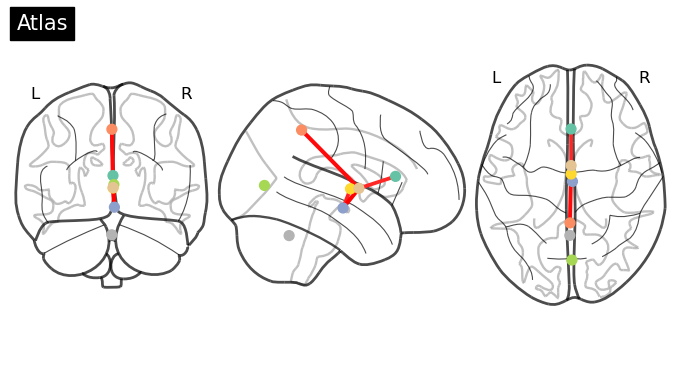

In [62]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="Atlas",
)

In [148]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/7/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 7, 7])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

#### Distinguishing the groups for L/R hemispheres --> 15 groups 

In [136]:
## HO atlas
brain_region_groups = {
    "Frontal Lobe Regions": [
        "Left Frontal Pole", "Right Frontal Pole",
        "Left Superior Frontal Gyrus", "Right Superior Frontal Gyrus",
        "Left Middle Frontal Gyrus", "Right Middle Frontal Gyrus",
        "Left Inferior Frontal Gyrus, pars triangularis", "Right Inferior Frontal Gyrus, pars triangularis",
        "Left Inferior Frontal Gyrus, pars opercularis", "Right Inferior Frontal Gyrus, pars opercularis",
        "Left Precentral Gyrus", "Right Precentral Gyrus",
        "Left Frontal Medial Cortex", "Right Frontal Medial Cortex",
        "Left Frontal Orbital Cortex", "Right Frontal Orbital Cortex",
        "Left Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)", "Right Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)",
        "Left Frontal Operculum Cortex", "Right Frontal Operculum Cortex"
    ],
    "Temporal Lobe Regions": [
        "Left Temporal Pole", "Right Temporal Pole",
        "Left Superior Temporal Gyrus, anterior division", "Right Superior Temporal Gyrus, anterior division",
        "Left Superior Temporal Gyrus, posterior division", "Right Superior Temporal Gyrus, posterior division",
        "Left Middle Temporal Gyrus, anterior division", "Right Middle Temporal Gyrus, anterior division",
        "Left Middle Temporal Gyrus, posterior division", "Right Middle Temporal Gyrus, posterior division",
        "Left Middle Temporal Gyrus, temporooccipital part", "Right Middle Temporal Gyrus, temporooccipital part",
        "Left Inferior Temporal Gyrus, anterior division", "Right Inferior Temporal Gyrus, anterior division",
        "Left Inferior Temporal Gyrus, posterior division", "Right Inferior Temporal Gyrus, posterior division",
        "Left Inferior Temporal Gyrus, temporooccipital part", "Right Inferior Temporal Gyrus, temporooccipital part",
        "Left Temporal Fusiform Cortex, anterior division", "Right Temporal Fusiform Cortex, anterior division",
        "Left Temporal Fusiform Cortex, posterior division", "Right Temporal Fusiform Cortex, posterior division",
        "Left Temporal Occipital Fusiform Cortex", "Right Temporal Occipital Fusiform Cortex",
        "Left Planum Polare", "Right Planum Polare",
        "Left Heschl's Gyrus (includes H1 and H2)", "Right Heschl's Gyrus (includes H1 and H2)",
        "Left Planum Temporale", "Right Planum Temporale"
    ],
    "Parietal Lobe Regions": [
        "Left Superior Parietal Lobule", "Right Superior Parietal Lobule",
        "Left Supramarginal Gyrus, anterior division", "Right Supramarginal Gyrus, anterior division",
        "Left Supramarginal Gyrus, posterior division", "Right Supramarginal Gyrus, posterior division",
        "Left Angular Gyrus", "Right Angular Gyrus",
        "Left Central Opercular Cortex", "Right Central Opercular Cortex",
        "Left Parietal Operculum Cortex", "Right Parietal Operculum Cortex"
    ],
    "Occipital Lobe Regions": [
        "Left Lateral Occipital Cortex, superior division", "Right Lateral Occipital Cortex, superior division",
        "Left Lateral Occipital Cortex, inferior division", "Right Lateral Occipital Cortex, inferior division",
        "Left Intracalcarine Cortex", "Right Intracalcarine Cortex",
        "Left Cuneal Cortex", "Right Cuneal Cortex",
        "Left Precuneous Cortex", "Right Precuneous Cortex",
        "Left Supracalcarine Cortex", "Right Supracalcarine Cortex",
        "Left Occipital Fusiform Gyrus", "Right Occipital Fusiform Gyrus",
        "Left Occipital Pole", "Right Occipital Pole"
    ],
    "Insular Cortex": [
        "Left Insular Cortex", "Right Insular Cortex"
    ],
    "Limbic System Regions": [
        "Left Parahippocampal Gyrus, anterior division", "Right Parahippocampal Gyrus, anterior division",
        "Left Parahippocampal Gyrus, posterior division", "Right Parahippocampal Gyrus, posterior division",
        "Left Cingulate Gyrus, anterior division", "Right Cingulate Gyrus, anterior division",
        "Left Cingulate Gyrus, posterior division", "Right Cingulate Gyrus, posterior division",
        "Left Subcallosal Cortex", "Right Subcallosal Cortex",
        "Left Paracingulate Gyrus", "Right Paracingulate Gyrus",
        "Left Lingual Gyrus", "Right Lingual Gyrus"
    ],
    "Cerebral White Matter": [
        "Left Cerebral White Matter", "Right Cerebral White Matter"
    ],
    "Cerebral Cortex": [
        "Left Cerebral Cortex ", "Right Cerebral Cortex "
    ],
    "Lateral Ventricles": [
        "Left Lateral Ventrical", "Right Lateral Ventricle"
    ],
    "Thalamus": [
        "Left Thalamus", "Right Thalamus"
    ],
    "Caudate Nucleus": [
        "Left Caudate", "Right Caudate"
    ],
    "Putamen": [
        "Left Putamen", "Right Putamen"
    ],
    "Pallidum": [
        "Left Pallidum", "Right Pallidum"
    ],
    "Hippocampus and Amygdala": [
        "Left Hippocampus", "Right Hippocampus",
        "Left Amygdala", "Right Amygdala"
    ],
    "Other Structures": [
        "Brain-Stem",
        "Left Accumbens", "Right Accumbens",
        "Background"
    ]
}
len(brain_region_groups)

15

In [64]:
## AAL atlas
brain_region_groups = {
    "Frontal Lobe Regions - Left": [
        "Precentral_L",
        "Frontal_Sup_L",
        "Frontal_Sup_Orb_L",
        "Frontal_Mid_L",
        "Frontal_Mid_Orb_L",
        "Frontal_Inf_Oper_L",
        "Frontal_Inf_Tri_L",
        "Frontal_Inf_Orb_L",
        "Rolandic_Oper_L",
        "Supp_Motor_Area_L",
        "Olfactory_L",
        "Frontal_Sup_Medial_L",
        "Frontal_Med_Orb_L",
        "Rectus_L"
    ],
    "Frontal Lobe Regions - Right": [
        "Precentral_R",
        "Frontal_Sup_R",
        "Frontal_Sup_Orb_R",
        "Frontal_Mid_R",
        "Frontal_Mid_Orb_R",
        "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_R",
        "Rolandic_Oper_R",
        "Supp_Motor_Area_R",
        "Olfactory_R",
        "Frontal_Sup_Medial_R",
        "Frontal_Med_Orb_R",
        "Rectus_R"
    ],
    "Parietal Lobe Regions - Left": [
        "Postcentral_L",
        "Parietal_Sup_L",
        "Parietal_Inf_L",
        "SupraMarginal_L",
        "Angular_L",
        "Precuneus_L",
        "Paracentral_Lobule_L"
    ],
    "Parietal Lobe Regions - Right": [
        "Postcentral_R",
        "Parietal_Sup_R",
        "Parietal_Inf_R",
        "SupraMarginal_R",
        "Angular_R",
        "Precuneus_R",
        "Paracentral_Lobule_R"
    ],
    "Temporal Lobe Regions - Left": [
        "Heschl_L",
        "Temporal_Sup_L",
        "Temporal_Pole_Sup_L",
        "Temporal_Mid_L",
        "Temporal_Pole_Mid_L",
        "Temporal_Inf_L"
    ],
    "Temporal Lobe Regions - Right": [
        "Heschl_R",
        "Temporal_Sup_R",
        "Temporal_Pole_Sup_R",
        "Temporal_Mid_R",
        "Temporal_Pole_Mid_R",
        "Temporal_Inf_R"
    ],
    "Occipital Lobe Regions - Left": [
        "Calcarine_L",
        "Cuneus_L",
        "Lingual_L",
        "Occipital_Sup_L",
        "Occipital_Mid_L",
        "Occipital_Inf_L",
        "Fusiform_L"
    ],
    "Occipital Lobe Regions - Right": [
        "Calcarine_R",
        "Cuneus_R",
        "Lingual_R",
        "Occipital_Sup_R",
        "Occipital_Mid_R",
        "Occipital_Inf_R",
        "Fusiform_R"
    ],
    "Limbic Lobe Regions - Left": [
        "Insula_L",
        "Cingulum_Ant_L",
        "Cingulum_Mid_L",
        "Cingulum_Post_L",
        "Hippocampus_L",
        "ParaHippocampal_L",
        "Amygdala_L"
    ],
    "Limbic Lobe Regions - Right": [
        "Insula_R",
        "Cingulum_Ant_R",
        "Cingulum_Mid_R",
        "Cingulum_Post_R",
        "Hippocampus_R",
        "ParaHippocampal_R",
        "Amygdala_R"
    ],
    "Subcortical Structures - Left": [
        "Caudate_L",
        "Putamen_L",
        "Pallidum_L",
        "Thalamus_L"
    ],
    "Subcortical Structures - Right": [
        "Caudate_R",
        "Putamen_R",
        "Pallidum_R",
        "Thalamus_R"
    ],
    "Cerebellar Regions - Left": [
        "Cerebelum_Crus1_L",
        "Cerebelum_Crus2_L",
        "Cerebelum_3_L",
        "Cerebelum_4_5_L",
        "Cerebelum_6_L",
        "Cerebelum_7b_L",
        "Cerebelum_8_L",
        "Cerebelum_9_L",
        "Cerebelum_10_L"
    ],
    "Cerebellar Regions - Right": [
        "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_R",
        "Cerebelum_3_R",
        "Cerebelum_4_5_R",
        "Cerebelum_6_R",
        "Cerebelum_7b_R",
        "Cerebelum_8_R",
        "Cerebelum_9_R",
        "Cerebelum_10_R"
    ],
    "Vermis Regions": [
        "Vermis_1_2",
        "Vermis_3",
        "Vermis_4_5",
        "Vermis_6",
        "Vermis_7",
        "Vermis_8",
        "Vermis_9",
        "Vermis_10"
    ]
}

In [139]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 15, 15)
0


/opt/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


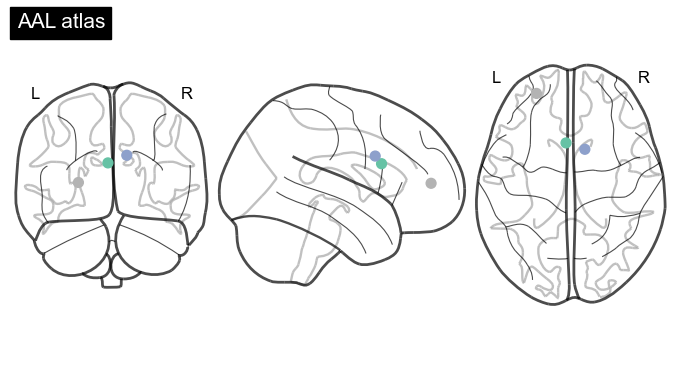

In [141]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # keep only indices that are in the corr_matrix
    indices = [x for x in indices if x < agg_data_manual.shape[1]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="AAL atlas",
)

In [143]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 15, 15])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

#### Fine-grained 17 groups

In [23]:
## AAL atlas
brain_region_groups = {
    "Frontal Lobe - Superior Regions": [
        "Frontal_Sup_L", "Frontal_Sup_R",
        "Frontal_Sup_Orb_L", "Frontal_Sup_Orb_R",
        "Frontal_Sup_Medial_L", "Frontal_Sup_Medial_R"
    ],
    "Frontal Lobe - Middle Regions": [
        "Frontal_Mid_L", "Frontal_Mid_R",
        "Frontal_Mid_Orb_L", "Frontal_Mid_Orb_R",
        "Frontal_Med_Orb_L", "Frontal_Med_Orb_R"
    ],
    "Frontal Lobe - Inferior Regions": [
        "Frontal_Inf_Oper_L", "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_L", "Frontal_Inf_Orb_R"
    ],
    "Precentral and Motor Areas": [
        "Precentral_L", "Precentral_R",
        "Rolandic_Oper_L", "Rolandic_Oper_R",
        "Supp_Motor_Area_L", "Supp_Motor_Area_R"
    ],
    "Olfactory and Rectus Regions": [
        "Olfactory_L", "Olfactory_R",
        "Rectus_L", "Rectus_R"
    ],
    "Parietal Lobe - Superior Regions": [
        "Parietal_Sup_L", "Parietal_Sup_R",
        "Precuneus_L", "Precuneus_R"
    ],
    "Parietal Lobe - Inferior Regions": [
        "Parietal_Inf_L", "Parietal_Inf_R",
        "SupraMarginal_L", "SupraMarginal_R",
        "Angular_L", "Angular_R"
    ],
    "Postcentral and Paracentral Regions": [
        "Postcentral_L", "Postcentral_R",
        "Paracentral_Lobule_L", "Paracentral_Lobule_R"
    ],
    "Temporal Lobe - Superior Regions": [
        "Temporal_Sup_L", "Temporal_Sup_R",
        "Temporal_Pole_Sup_L", "Temporal_Pole_Sup_R"
    ],
    "Temporal Lobe - Middle Regions": [
        "Temporal_Mid_L", "Temporal_Mid_R",
        "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R"
    ],
    "Temporal Lobe - Inferior Regions": [
        "Temporal_Inf_L", "Temporal_Inf_R",
        "Heschl_L", "Heschl_R"
    ],
    "Occipital Lobe Regions": [
        "Calcarine_L", "Calcarine_R",
        "Cuneus_L", "Cuneus_R",
        "Lingual_L", "Lingual_R",
        "Occipital_Sup_L", "Occipital_Sup_R",
        "Occipital_Mid_L", "Occipital_Mid_R",
        "Occipital_Inf_L", "Occipital_Inf_R"
    ],
    "Fusiform and Insular Regions": [
        "Fusiform_L", "Fusiform_R",
        "Insula_L", "Insula_R"
    ],
    "Limbic Lobe Regions": [
        "Cingulum_Ant_L", "Cingulum_Ant_R",
        "Cingulum_Mid_L", "Cingulum_Mid_R",
        "Cingulum_Post_L", "Cingulum_Post_R",
        "Hippocampus_L", "Hippocampus_R",
        "ParaHippocampal_L", "ParaHippocampal_R",
        "Amygdala_L", "Amygdala_R"
    ],
    "Subcortical Nuclei": [
        "Caudate_L", "Caudate_R",
        "Putamen_L", "Putamen_R",
        "Pallidum_L", "Pallidum_R",
        "Thalamus_L", "Thalamus_R"
    ],
    "Cerebellar Hemispheres": [
        "Cerebelum_Crus1_L", "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_L", "Cerebelum_Crus2_R",
        "Cerebelum_3_L", "Cerebelum_3_R",
        "Cerebelum_4_5_L", "Cerebelum_4_5_R",
        "Cerebelum_6_L", "Cerebelum_6_R",
        "Cerebelum_7b_L", "Cerebelum_7b_R",
        "Cerebelum_8_L", "Cerebelum_8_R",
        "Cerebelum_9_L", "Cerebelum_9_R",
        "Cerebelum_10_L", "Cerebelum_10_R"
    ],
    "Cerebellar Vermis Regions":[
        "Vermis_1_2", "Vermis_3", 
        "Vermis_4_5", "Vermis_6", 
        "Vermis_7", "Vermis_8", 
        "Vermis_9", "Vermis_10"
    ]
}

In [24]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 17, 17)
0


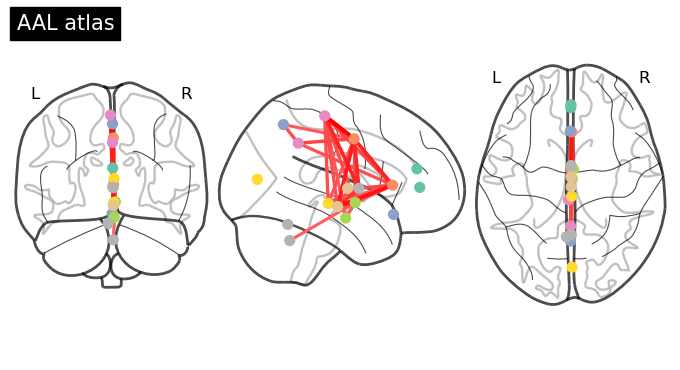

In [25]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="AAL atlas",
)

In [ ]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])

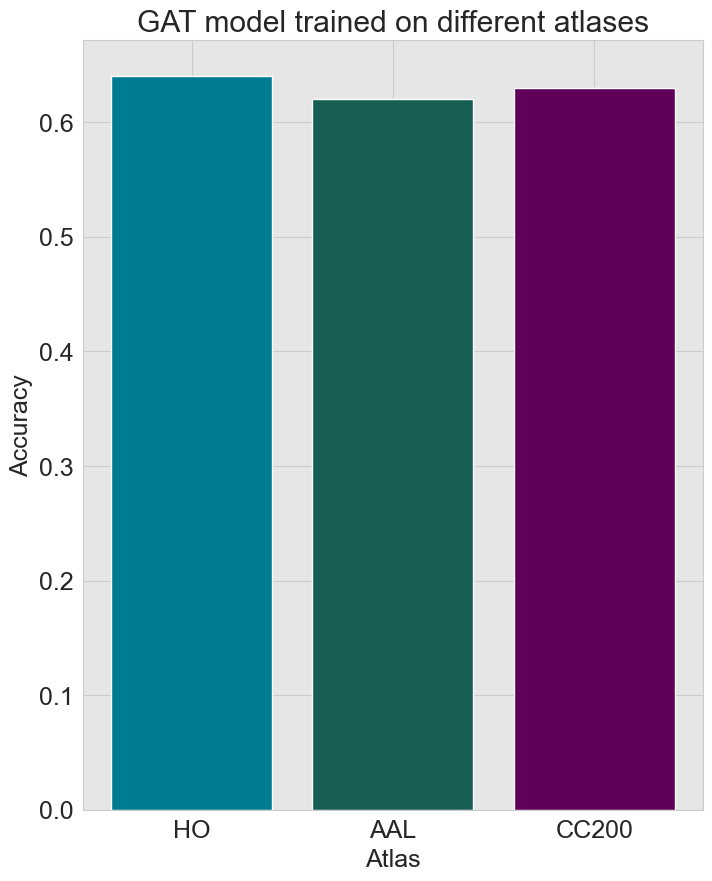

In [104]:
# Create a histogram with accuracies for 3 models trained on HO, AAL and CC200
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_style('whitegrid', {'axes.facecolor': '.9'})
plt.figure(figsize=(8, 10))
plt.bar([0, 1, 2], [0.6270, 0.6071, 0.63], color=['#007c92', '#175e54', '#610059'])
plt.xlabel('Atlas')
plt.xticks([0, 1, 2], ['HO', 'AAL', 'CC200'])
plt.ylabel('Accuracy')
plt.title('GAT model trained on different atlases')
plt.show()
